In [100]:
import sympy as sp
import numpy as np
from numpy.random import normal
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
from utils import symdisp, symplot
import ipywidgets as widgets
from ipywidgets import interact
import scipy as scp

from optic.comm.modulation import modulateGray, demodulateGray, grayMapping, detector
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample, decimate, delaySignal, finddelay
from optic.comm.metrics import signalPower, fastBERcalc
from optic.plot import eyediagram, pconst, plotPSD
from optic.utils import parameters, dB2lin

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")
#mpl.rcParams['figure.dpi'] = 300

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
#plt.style.use(["science"])

In [6]:
from IPython.core.pylabtools import figsize
figsize(6, 2)

# Transmissão Digital da Informação

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Canais-limitados-em-banda" data-toc-modified-id="Canais-limitados-em-banda-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Canais limitados em banda</a></span></li><li><span><a href="#Sinalização-para-canais-limitados-em-banda" data-toc-modified-id="Sinalização-para-canais-limitados-em-banda-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sinalização para canais limitados em banda</a></span><ul class="toc-item"><li><span><a href="#Interferência-intersimbólica-(ISI)" data-toc-modified-id="Interferência-intersimbólica-(ISI)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Interferência intersimbólica (ISI)</a></span></li><li><span><a href="#Critério-de-Nyquist-para-ausência-de-interferência-intersimbólica" data-toc-modified-id="Critério-de-Nyquist-para-ausência-de-interferência-intersimbólica-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Critério de Nyquist para ausência de interferência intersimbólica</a></span></li><li><span><a href="#Família-de-pulsos-cosseno-levantado-(raised-cosine)" data-toc-modified-id="Família-de-pulsos-cosseno-levantado-(raised-cosine)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Família de pulsos cosseno levantado (<em>raised cosine</em>)</a></span></li><li><span><a href="#Transmissão-de-sinais-com-resposta-parcial" data-toc-modified-id="Transmissão-de-sinais-com-resposta-parcial-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Transmissão de sinais com <em>resposta parcial</em></a></span></li><li><span><a href="#Detecção-símbolo-a-símbolo-de-sinais-com-ISI-controlada" data-toc-modified-id="Detecção-símbolo-a-símbolo-de-sinais-com-ISI-controlada-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Detecção símbolo-a-símbolo de sinais com ISI controlada</a></span></li></ul></li><li><span><a href="#Detecção-de-sequências-por-máxima-verossimilhança" data-toc-modified-id="Detecção-de-sequências-por-máxima-verossimilhança-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Detecção de sequências por máxima verossimilhança</a></span></li><li><span><a href="#Referências" data-toc-modified-id="Referências-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Referências</a></span></li></ul></div>

# Equalização em canais de comunicação

<img src="./figuras/Fig1.png" width="900">
 <center>Fig.1: Diagrama de blocos de um sistema de transmissão digital genérico.</center>

##  Canais distorcivos e limitados em banda

Na análise que segue, considere que o canal de comunicações pode ser modelado como um sistema linear com uma resposta ao impulso $h(t)$ e resposta em frequência $H(f)$ limitada a uma banda de $B$ Hz, de modo que 

$$
\begin{equation}
H(f) = \begin{cases}|H(f)|e^{\theta(f)}, & |f|<B \\ 0, & \text { caso contrário.}\end{cases}
\end{equation}
$$

e $H(f) = \int_{-\infty}^{\infty}h(t)e^{-2\pi f t} dt$, $|H(f)|$ é a resposta de amplitude e $\theta(f)$ a resposta de fase do canal. A partir da resposta de fase podemos definir o *atraso de grupo* como 

$$
\begin{equation}
\tau(f)=-\frac{1}{2 \pi} \frac{d \theta(f)}{d f}.
\end{equation}
$$

O atraso de grupo corresponde ao intervalo de tempo com que cada componente de frequência do sinal transmitido atravessa o canal linear. Um canal linear causará distorção nos sinais por ele transmitidos se $|H(f)|$ não for constante ou $\theta(f)$ não for uma função linear de $f$, ou seja, se o atraso de grupo não for constante para todos os componentes de frequência dentro da banda do canal.

<img src="./figuras/Fig14.png" width="800">

<center>Fig.2: Esquemático de um sistema de transmissão digital via canal linear e AWGN.</center>

### Interferência intersimbólica (ISI)

Assuma que no receptor o sinal $r(t)$ é filtrado e amostrado nos instantes $t=qT_s + \tau_{0}, q=0, 1, \ldots$. Seja a saída do filtro do receptor dada por

$$
\begin{equation}
y(t)=\sum_{k=-\infty}^{\infty} s_k x(t-kT_s) + v(t)
\end{equation}
$$

em que o pulso $x(t)$ é o resultado da convolução do pulso original $p(t)$ com a resposta ao impulso do canal $h(t)$ e a resposta ao impulso do filtro do recetor $p_{R}(t)$ e $v(t)$ é o resultado da convolução entre o ruído gaussiano na entrada do receptor e $p_{R}(t)$. Considerando apenas a representação discreta do sinal, temos
$$
\begin{equation}\label{ISI_eq1}
y[k]=s[k] + \sum_{\substack{n=-\infty \\ n \neq k}}^{\infty} s[n] x[k-n] + v[k], \quad k=0,1, \ldots
\end{equation}
$$

Em ($\ref{ISI_eq1}$), temos que $s[k]$ é o símbolo transmitido no intervalo de sinalização $k$. Já o termo $\sum_{\substack{n=-\infty \\ n \neq k}}^{\infty} s[n] x[k-n]$ representa a interferência causada em $s[k]$ pelos demais símbolos transmitidos, denominada **interferência intersimbólica** (*intersymbol interference* - ISI). Por fim, $v[k]$ é uma variável aleatória representado o ruído no instante de sinalização $k$.


### Minimização do critério do pico de distorção (*peak distortion criterion*)

Considere que utilizaremos como equalizador de $y[k]$ um filtro linear discreto no tempo com resposta ao impulso $c[m]$, de modo que
$$
z[k]=\sum_{m=-\infty}^{\infty} c[m]\,y[k-m].
$$
onde $z[k]$ é a saída do equalizador.

Substituindo $y[k]$ e reorganizando, temos
$$
z[k]=\sum_{n=-\infty}^{\infty} s[n]\,g[k-n] + w[k],
$$
onde a resposta equivalente é
$$
g[\ell]\triangleq c[\ell]\ast x[\ell] = \sum_{m=-\infty}^{\infty} c[m]\,x[\ell-m],
\qquad
w[k]\triangleq \sum_{m=-\infty}^{\infty} c[m]\,v[k-m].
$$
Assim,
$$
z[k]=s[k]g[0]+\sum_{\substack{n=-\infty \\ n \neq k}}^{\infty} s[n]g[k-n]+w[k].
$$

Normalizando o resultado por $g[0]$, temos

$$
z[k]=s[k]+\sum_{\substack{n=-\infty \\ n \neq k}}^{\infty} s[n]g[k-n]+w[k].
$$

Defina a distorção de pico como a energia dos termos fora do pico desejado
(assumindo pico em $\ell=0$):
$$
D(c) \triangleq \sum_{\substack{\ell=-\infty \\ \ell \neq 0}}^{\infty} |g[\ell]|^2.
$$


Como $D(c)\ge 0$, o mínimo global ocorre quando $D(c)=0$, isto é,

$$
g[\ell] = \delta[\ell] =
\begin{cases}
1, & \ell = 0 \\
0, & \ell \neq 0
\end{cases}
$$


Como $g[\ell]=c[\ell]\ast x[\ell]$, a condição ótima é
$$
c[\ell]\ast x[\ell]=\delta[\ell].
$$

No domínio-$z$,
$$
C(z)X(z) = 1,
\qquad
C(z)=\frac{1}{X(z)}.
$$

Sabemos que $X(z)=P_T(z)H(z)P_R(z)$. Logo, se $P_T(z)$ e $P_R(z)$ resultarem num pulso livre de ISI, basta que $$C(z)=\frac{1}{H(z)},$$

para que a saída do equalizador esteja livre de ISI.

### Exemplo: aplicação de um equalizador ZF para compensação de ISI num canal linear

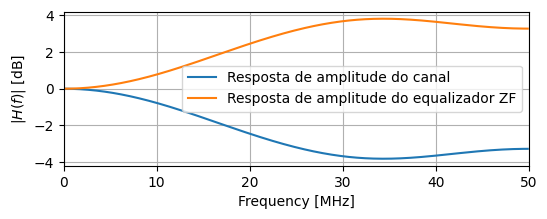

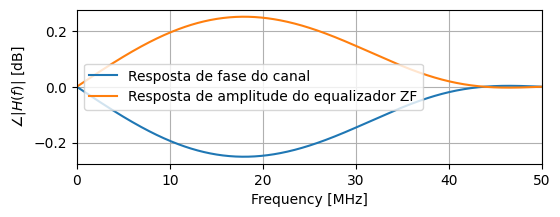

In [72]:
# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fs  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)

# resposta do canal linear

# Canal FIR (5 taps) mínimo-fase (zeros em 0.5, -0.3, ±j0.2)
h_ch = np.array([1, 0.2, 0.11, 0.008, 0.006])
h_ch /= np.sum(h_ch)

fs = Rs
ω, H_ch = scp.signal.freqz(b=h_ch, a=1)
ω, H_zf = scp.signal.freqz(b=1, a=h_ch)

x = ω * fs * 1.0 / (2 * np.pi)

plt.figure(1)
plt.plot(x/1e6, 20*np.log10(np.abs(H_ch)), label = 'Resposta de amplitude do canal')
plt.plot(x/1e6, 20*np.log10(np.abs(H_zf)), label = 'Resposta de amplitude do equalizador ZF')
plt.ylabel('$|H(f)|$ [dB]')
plt.xlabel('Frequency [MHz]')
plt.legend()
plt.xlim(0,Rs/2/1e6);
plt.grid()

plt.figure(2)
plt.plot(x/1e6, np.unwrap(np.angle(H_ch)), label = 'Resposta de fase do canal')
plt.plot(x/1e6, np.unwrap(np.angle(H_zf)), label = 'Resposta de amplitude do equalizador ZF')
plt.ylabel('$\\angle |H(f)|$ [dB]')
plt.xlabel('Frequency [MHz]')
plt.legend()
plt.xlim(0,Rs/2/1e6);
plt.grid()


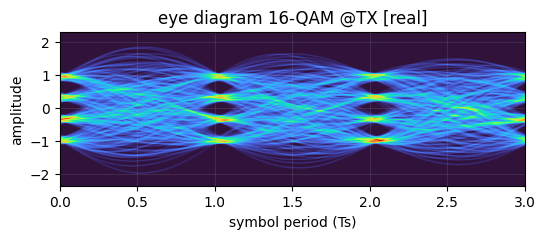

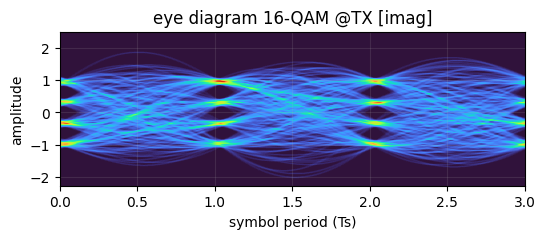

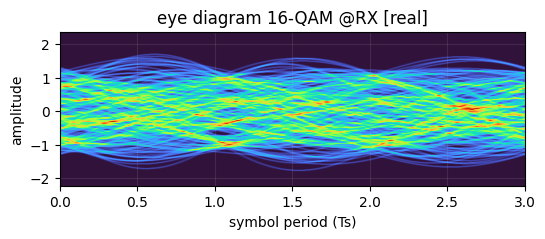

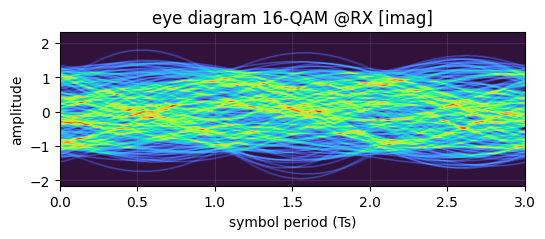

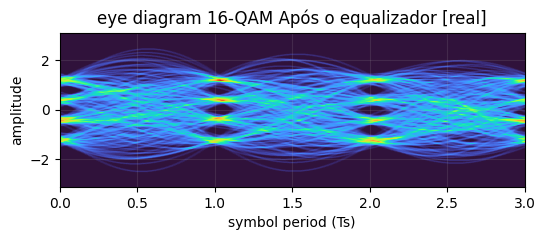

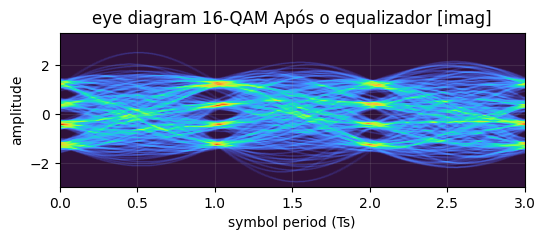

In [118]:
M = 16
constType = 'qam'
SNR = 20

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(250000*np.log2(M)))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)
h_ch_Up = upsample(h_ch, SpS)

# pulso RRC
paramPS = parameters()
paramPS.pulseType = 'rrc'
paramPS.SpS = SpS
paramPS.nFilterTaps = 1024
paramPS.rollOff = 0.05

pulse = pulseShape(paramPS)

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = pnorm(sigTx)

# canal linear
sigRx = firFilter(h_ch_Up, sigTx)
sigRx = pnorm(sigRx)

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 1/dB2lin(SNR) # variância

σ      = np.sqrt(σ2*SpS)
ruido  = normal(0, σ, Namostras)
ruidoC  = (normal(0, σ, Namostras) + 1j*normal(0, σ, Namostras))/np.sqrt(2)

# diagrama de olho
Nsamples = sigTx.size
if constType == 'pam':
    sigRx += ruido
    
    # filtro casado
    sigRx = firFilter(pulse, sigRx)
    sigRx = delaySignal(sigRx, -0.6/Rs, Fs, 512).flatten()
    
    # Equalizador ZF
    sigRx_eq = scp.signal.lfilter(1, h_ch_Up, sigRx)     
    
    eyediagram(sigTx.real, Nsamples, SpS, plotlabel= str(M)+'-PAM', ptype='fancy')
    eyediagram(sigRx, Nsamples, SpS, plotlabel= str(M)+'-PAM', ptype='fancy')
    eyediagram(sigRx_eq, Nsamples, SpS, plotlabel= str(M)+'-PAM', ptype='fancy')
else:
    sigRx += ruidoC
    
    # filtro casado
    sigRx = firFilter(pulse, sigRx)
    sigRx = delaySignal(sigRx, -0.6/Rs, Fs, 512).flatten()
    
    # Equalizador ZF
    sigRx_eq = scp.signal.lfilter(1, h_ch_Up, sigRx)

    eyediagram(sigTx, Nsamples, SpS, plotlabel= str(M)+'-QAM @TX', ptype='fancy')
    eyediagram(sigRx, Nsamples, SpS, plotlabel= str(M)+'-QAM @RX', ptype='fancy')
    eyediagram(sigRx_eq, Nsamples, SpS, plotlabel= str(M)+'-QAM Após o equalizador', ptype='fancy')

# plot PSD
plt.figure(figsize=(6,3));
plt.xlim(-2*Rs/1e6,2*Rs/1e6);
plt.ylim(-90,-10);
plt.psd(sigTx, Fs=Fs/1e6, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Tx (entrada do canal)')
plt.psd(firFilter(h_ch_Up, sigTx),Fs=Fs/1e6, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (saída do canal)')
plt.xlabel('Frequency [MHz]')
plt.legend(loc='lower left');

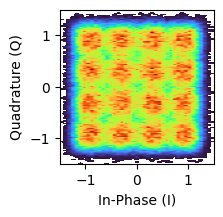

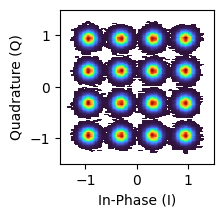

In [119]:
# downsampling
paramDec = parameters()
paramDec.SpSin = SpS
paramDec.SpSout = 1
r = decimate(sigRx, paramDec)
r_eq = decimate(sigRx_eq, paramDec)

discard=100
pconst(r[discard:-discard], pType='fancy', R=1.5);
pconst(r_eq[discard:-discard], pType='fancy', R=1.5);

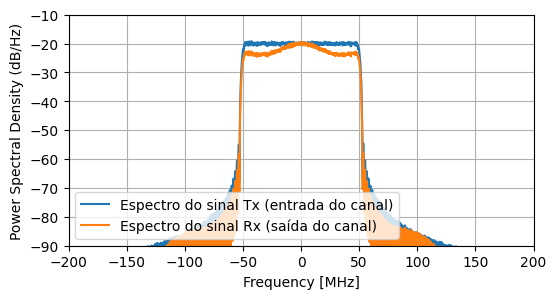

In [122]:
# plot PSD
plt.figure(figsize=(6,3));
plt.xlim(-2*Rs/1e6,2*Rs/1e6);
plt.ylim(-90,-10);
plt.psd(sigTx,Fs=Fs/1e6, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Tx (entrada do canal)')
plt.psd(firFilter(h_ch_Up, sigTx),Fs=Fs/1e6, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (saída do canal)')
plt.xlabel('Frequency [MHz]')
plt.legend(loc='lower left');

In [130]:
d = finddelay(r, symbTx)
r = pnorm(np.roll(r,-d))

d = finddelay(r_eq, symbTx)
r_eq = pnorm(np.roll(r_eq,-d))

discard = 1000
BER, SER, SNR = fastBERcalc(r[discard:-discard], symbTx[discard:-discard], M, 'qam')
BER_eq, SER_eq, SNR_eq = fastBERcalc(r_eq[discard:-discard], symbTx[discard:-discard], M, 'qam')
print('Resultados:\n')
print('Sem equalizador | Com equalizador ZF')
print(f'BER = {BER[0]:.2e}  | BER = {BER_eq[0]:.2e}')
print(f'SER = {SER[0]:.2e}  | SER = {SER_eq[0]:.2e}')
print(f'SNR = {SNR[0]:.2f} dB  | SNR = {SNR_eq[0]:.2f} dB')

Resultados:

Sem equalizador | Com equalizador ZF
BER = 3.40e-02  | BER = 3.13e-05
SER = 1.32e-01  | SER = 1.25e-04
SNR = 11.64 dB  | SNR = 18.91 dB
